In [29]:
%load_ext sql

In [30]:
%config SqlMagic.displaylimit = 15
# %config SqlMagic.displaylimit = None

In [2]:
import datetime as dt
import sqlite3
import pandas as pd
from sqlalchemy import create_engine, text

In [594]:
sys_log_db = "system_data_log.db"

sql_engine = create_engine("sqlite:///%s" % sys_log_db, echo=False)

In [189]:
def create_voltage_table(force=False):
    with sql_engine.connect() as sql_conn:
        if force:
            sql_text = text("""DROP TABLE IF EXISTS voltages;
                            """)
            sql_conn.execute(sql_text)
        # define schema
        sql_text = text("""
            CREATE TABLE IF NOT EXISTS voltages (
                Timestamp TEXT,
                Vmain FLOAT,
                Vmain_raw FLOAT,
                Vaux FLOAT,
                Vaux_raw FLOAT,
                PRIMARY KEY (Timestamp)
                )
        """)
        sql_conn.execute(sql_text)
        sql_conn.commit()

In [ ]:
create_voltage_table()

In [193]:
def add_voltage_log(Vmain, Vmain_raw, Vaux, Vaux_raw):
    with sql_engine.connect() as sql_conn:
        sql_text = text("""INSERT INTO voltages
                           VALUES (DateTime("now", "localtime"),
                                   :v_main,
                                   :v_main_raw,
                                   :v_aux,
                                   :v_aux_raw
                           );
                        """)
        sql_conn.execute(sql_text, {"v_main": Vmain,
                                    "v_main_raw": Vmain_raw,
                                    "v_aux": Vaux,
                                    "v_aux_raw": Vaux_raw})
        sql_conn.commit()

In [194]:
add_voltage_log(12.4, 12.8, 12.5, 12)

In [282]:
def get_voltages(voltage_type="Vmain", trailing_seconds=None):
    with sql_engine.connect() as sql_conn:
        sql_text = text(f"""SELECT Timestamp, {voltage_type}
                            FROM voltages
                         """)
        result_df = pd.read_sql(sql_text, con=sql_conn, index_col = "Timestamp", parse_dates=["Timestamp"])
    if trailing_seconds is not None:
        return result_df[result_df.index > dt.datetime.now() - dt.timedelta(seconds=trailing_seconds)]
    else:
        return result_df

In [595]:
def get_voltages(voltage_type=None, trailing_seconds=None):
    if voltage_type is None:
        cols = "*"
    else:
        cols = "Timestamp, %s" % voltage_type

    if trailing_seconds is not None:
        timestamp_now = dt.datetime.now()
        timestamp_trail = timestamp_now - dt.timedelta(seconds=trailing_seconds)
        timestamp_trail_str = timestamp_trail.strftime("%Y-%m-%d %H:%M:%S")
        time_filter = "WHERE Timestamp > %s" % timestamp_trail_str
    else:
        time_filter = ""

    with sql_engine.connect() as sql_conn:
        # sql_text = text(f"""SELECT Timestamp, {voltage_type}
        sql_text = text(f"""SELECT {cols}
                            FROM voltages
                            {time_filter}
                         """)
        result_df = pd.read_sql(sql_text, con=sql_conn, index_col = "Timestamp", parse_dates=["Timestamp"])
    return result_df

In [344]:
df = get_voltages("Vmain"); df

,Vmain
Timestamp,
2025-10-12 15:08:14,12.4
2025-10-12 15:08:21,12.4
2025-10-12 15:08:22,12.5


---

In [ ]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_sql.html
pandas.DataFrame.to_sql(sys_log_db, )

In [487]:
table_df = dl.get_charging(dt.datetime.now()); table_df

,charge_enable,charge_dir,charge_current,shunt_V_in,shunt_V_out
Timestamp,,,,,
2025-10-13 21:16:05,1,1,4.3,0.1,0.03
2025-10-13 21:16:45,1,1,4.3,0.1,0.03
2025-10-13 21:17:03,1,1,4.3,0.1,0.03
2025-10-13 21:17:50,1,1,4.3,0.1,0.03
2025-10-13 21:27:45,1,1,4.3,0.1,0.03
2025-10-13 21:28:15,1,1,4.3,0.1,0.03
2025-10-13 21:30:07,1,1,4.3,0.1,0.03


In [493]:
time_now = dt.datetime.now()

In [497]:
(time_now - table_df.index[-1]) > dt.timedelta(seconds=5)

True

In [498]:
table_df = dl.get_charging(dt.datetime.now(), 5); table_df

,charge_enable,charge_dir,charge_current,shunt_V_in,shunt_V_out
Timestamp,,,,,


In [499]:
len(table_df.index)

0

###
---

In [4]:
from importlib import reload
import class_def
reload(class_def)
dl = class_def.DataLogger()

In [644]:
dl._execute_sql("SELECT * FROM voltages", query=True)

,Vmain_raw,Vaux_raw
Timestamp,,
2025-10-17 20:41:13,12.298,12.909
2025-10-17 20:42:52,12.298,12.909
NaT,12.236,12.909
NaT,12.236,12.909
2025-10-17 21:09:41,12.220,12.909
...,...,...
2025-10-18 10:41:02,12.894,12.580
2025-10-18 10:41:03,12.894,12.580
2025-10-18 10:41:04,12.894,12.580


In [677]:
dl.get_voltages(dt.datetime.now(), 36000)

,Vmain_raw,Vaux_raw
Timestamp,,
2025-10-18 07:13:29,12.894,12.674
2025-10-18 07:13:30,12.894,12.674
2025-10-18 07:13:31,12.894,12.674
2025-10-18 07:13:32,12.894,12.674
2025-10-18 07:13:33,12.894,12.674
...,...,...
2025-10-18 17:11:33,12.909,12.659
2025-10-18 17:11:34,12.909,12.659
2025-10-18 17:11:35,12.909,12.659


In [637]:
dl.get_voltages(dt.datetime.now(), 1000, ["Vmain_raw"])

,Vmain_raw
Timestamp,
2025-10-18 08:15:10,12.894
2025-10-18 08:15:11,12.894
2025-10-18 08:15:12,12.894
2025-10-18 08:15:13,12.894
2025-10-18 08:15:14,12.894
...,...
2025-10-18 08:31:44,12.894
2025-10-18 08:31:45,12.894
2025-10-18 08:31:46,12.894


In [ ]:
dl.get_charging(dt.datetime.now())

,charge_enable,charge_dir,charge_current,shunt_V_in,shunt_V_out
Timestamp,,,,,
2025-10-17 20:42:52,0,1,8.266667,12.909,12.862
NaT,0,1,8.266667,12.909,12.878
NaT,0,1,8.266667,12.909,12.878
2025-10-17 21:09:41,0,1,8.533333,12.894,12.862
2025-10-17 21:09:42,0,1,8.266667,12.909,12.862
...,...,...,...,...,...
2025-10-18 07:49:00,1,1,12.533333,12.674,12.627
2025-10-18 07:49:01,1,1,12.533333,12.674,12.627
2025-10-18 07:49:02,1,1,8.533333,12.674,12.627


In [642]:
dl.get_signals(dt.datetime.now(), 10000)

,enable_sw,key_ACC,ecu_W,engine_on,network_conn,HAT_analog_0,HAT_analog_1,HAT_analog_2,HAT_input_0,HAT_input_1,HAT_input_2,HAT_relay_0,HAT_relay_1,HAT_relay_2
Timestamp,,,,,,,,,,,,,,


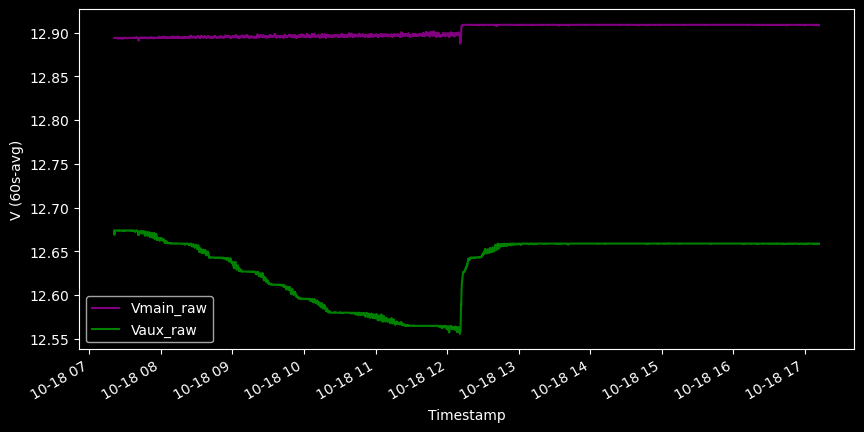

In [697]:
window_size_seconds = 60
dl.get_voltages(dt.datetime.now(), 36000).rolling(dt.timedelta(seconds=window_size_seconds)).mean().plot(figsize=(10, 5), ylabel="V (%ss-avg)" % window_size_seconds, color=("purple", "green"));
# dl.get_voltages(dt.datetime.now(), 3000).plot();

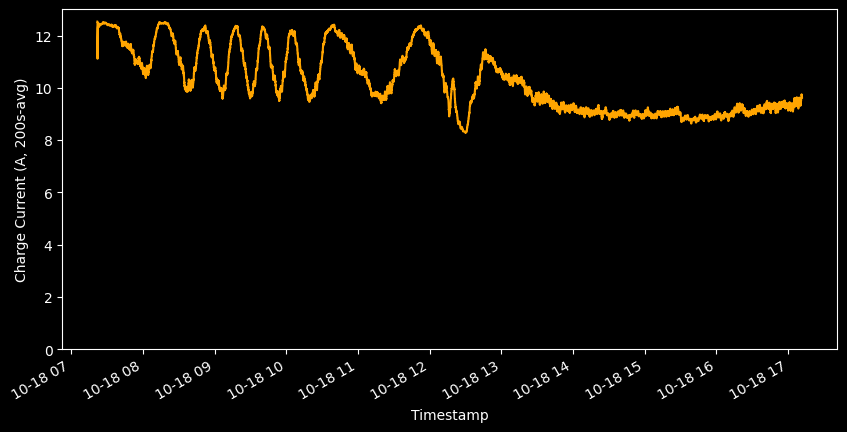

In [698]:
window_size_seconds = 200
dl.get_charging(dt.datetime.now(), 36000)["charge_current"].rolling(dt.timedelta(seconds=window_size_seconds)).mean().plot(figsize=(10, 5), ylim=(0, 13), ylabel="Charge Current (A, %ss-avg)" % window_size_seconds, color="orange");

### Energy use
---

In [719]:
charge_current = dl.get_charging(dt.datetime.now(), 10000)["charge_current"].rolling(dt.timedelta(seconds=10)).mean()
Vaux_raw = dl.get_voltages(dt.datetime.now(), 10000)["Vaux_raw"].rolling(dt.timedelta(seconds=10)).mean()

In [720]:
# Amp-hours, since index is seconds
charge_current.sum() / 3600

21.61312510288073

In [726]:
# time range in data
(charge_current.index[-1] - charge_current.index[0])

Timedelta('0 days 02:23:31')

In [736]:
# Converted to decimal hours
(charge_current.index[-1] - charge_current.index[0]).total_seconds()/3600

2.3919444444444444

In [728]:
# Avg current (Ah use per hour)
charge_current.mean()

9.070558448399467

In [ ]:
# Watts
charge_current * Vaux_raw

Timestamp
2025-10-18 14:41:58    108.023467
2025-10-18 14:41:59    108.023467
2025-10-18 14:42:00    108.023467
2025-10-18 14:42:01    108.023467
2025-10-18 14:42:02    108.023467
                          ...    
2025-10-18 17:11:33    122.168673
2025-10-18 17:11:34    122.168673
2025-10-18 17:11:35    122.168673
2025-10-18 17:11:36    122.168673
2025-10-18 17:11:37    121.897262
Length: 8946, dtype: float64

In [735]:
# kWh
(charge_current * Vaux_raw).sum() / 3600

273.508961070417

### 2025-10-24 key off, DC charger running and discharging Li batt all day, then recharging.
---

In [789]:
dt.datetime.strptime("20251024T1600", class_def.DATETIME_FORMAT)

datetime.datetime(2025, 10, 24, 16, 0)

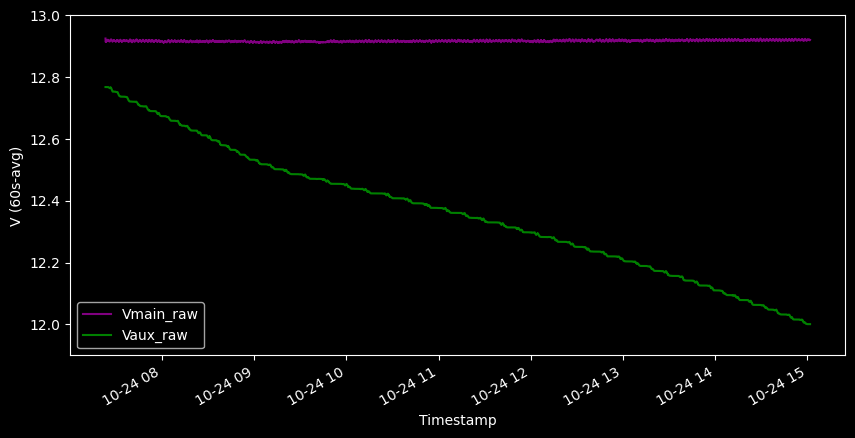

In [ ]:
# Key-off, system sitting idle all day.
window_size_seconds = 60
voltages = dl.get_voltages(dt.datetime.now(), 44500)
end_time = dt.datetime.strptime("20251024T1600", class_def.DATETIME_FORMAT)
voltages[voltages.index < end_time].rolling(dt.timedelta(seconds=window_size_seconds)).mean().plot(figsize=(10, 5), ylabel="V (%ss-avg)" % window_size_seconds, color=("purple", "green"), ylim=[11.9, 13]);

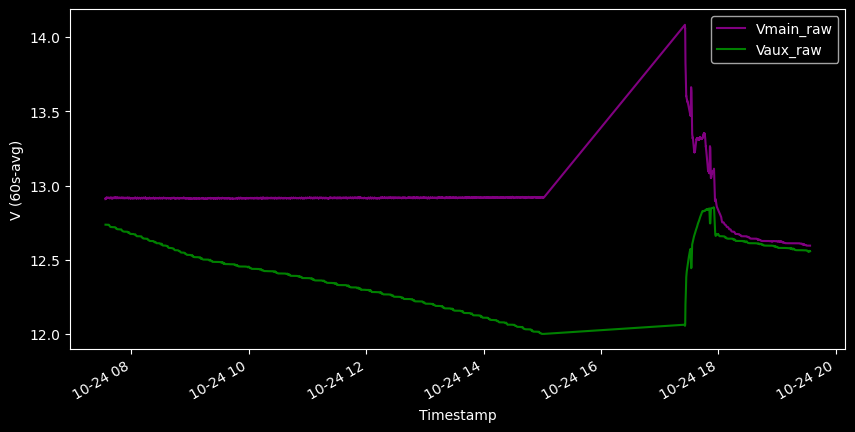

In [829]:
# Key-off, system sitting idle all day.
window_size_seconds = 60
voltages = dl.get_voltages(dt.datetime.now(), 44500)
voltages.rolling(dt.timedelta(seconds=window_size_seconds)).mean().plot(figsize=(10, 5), ylabel="V (%ss-avg)" % window_size_seconds, color=("purple", "green"));

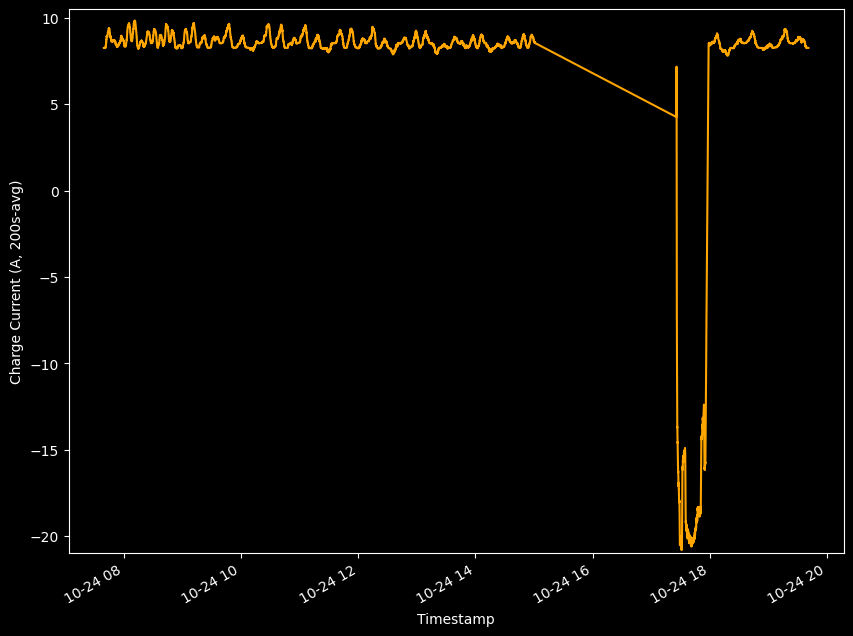

In [855]:
# Can see low charging current while system at idle, then much higher current after engine startup
# when alternator used to recharge Li batt from relatively low SoC.
# High current explains why I heard DC charger's fan turned on around 17:35 as well.
# Abrupt drop in current at end is turning engine off again and having charge direction reverse.
window_size_seconds = 200
charging_current = dl.get_charging(dt.datetime.now(), 45000, signed_charge_dir=True)["charge_current"]
charging_current.rolling(dt.timedelta(seconds=window_size_seconds)).mean().plot(figsize=(10, 8), ylim=(-21, 10.5), ylabel="Charge Current (A, %ss-avg)" % window_size_seconds, color="orange");

###
---

In [5]:
dl = class_def.DataLogger()

In [ ]:
sql_stmt = f"""SELECT Timestamp FROM signals
               ORDER BY Timestamp DESC
               LIMIT 1;
            """
# dl._execute_sql(sql_stmt, query=True).index.values[0]
# dt.datetime.strftime(dl._execute_sql(sql_stmt, query=True).index[0], class_def.DATETIME_FORMAT_SQL)
# dl._execute_sql(sql_stmt, query=True).index[0].strftime(class_def.DATETIME_FORMAT_SQL)
# dt.date.fromisoformat(dl._execute_sql(sql_stmt, query=True).index[0].strftime(class_def.DATETIME_FORMAT_SQL).split(" ")[0])
latest_date = dl._execute_sql(sql_stmt, query=True).index[0].date(); latest_date
latest_date - dt.timedelta(days=60)

datetime.date(2025, 9, 13)

In [ ]:
num_days = 60
sql_stmt = f"""SELECT Timestamp FROM signals
               ORDER BY Timestamp DESC
               LIMIT 1;
            """
latest_date = dl._execute_sql(sql_stmt, query=True).index[0].date()
old_date_cutoff = latest_date - dt.timedelta(days=num_days)
old_date_cutoff_str = old_date_cutoff.strftime(class_def.DATETIME_FORMAT_SQL)
date_filter = "WHERE Timestamp < '%s'" % old_date_cutoff_str
table = "signals"
sql_stmt = f"""DELETE
               FROM {table}
               {date_filter};
            """
dl._execute_sql(sql_stmt)

In [ ]:
sql_stmt = f"""SELECT * FROM signals
               ORDER BY Timestamp DESC
            """
dl._execute_sql(sql_stmt, query=True)

,enable_sw,key_ACC,ecu_W,engine_on,network_conn,HAT_analog_0,HAT_analog_1,HAT_analog_2,HAT_input_0,HAT_input_1,HAT_input_2,HAT_relay_0,HAT_relay_1,HAT_relay_2,PID
Timestamp,,,,,,,,,,,,,,,
2025-11-12 21:41:21,1,0,0,0,home network,12.157,12.189,12.377,0,0,1,1,0,1,29964.0
2025-11-12 21:41:20,1,0,0,0,home network,12.173,12.204,12.392,0,0,1,1,0,1,29964.0
2025-11-12 21:41:19,1,0,0,0,home network,12.173,12.204,12.377,0,0,1,1,0,1,29964.0
2025-11-12 21:41:18,1,0,0,0,home network,12.173,12.204,12.392,0,0,1,1,0,1,29964.0
2025-11-12 21:41:17,1,0,0,0,home network,12.173,12.204,12.377,0,0,1,1,0,1,29964.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-17 21:09:42,1,1,0,0,home network,12.878,12.909,12.220,0,1,1,0,0,1,NaN
2025-10-17 21:09:41,1,1,0,0,home network,12.862,12.909,12.220,0,1,1,0,0,1,NaN
NaT,1,1,0,0,home network,12.878,12.909,12.236,0,1,1,0,0,1,NaN
